In [1]:
!pip install networkx pulp gurobipy ortools matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


# Individual solver

In [ ]:
from ortools.linear_solver import pywraplp


def main():
    # Data
    costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Solver
    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver("SCIP")

    if not solver:
        return

    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, "")

    # Constraints
    # Each worker is assigned to at most 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

    # Each task is assigned to exactly one worker.
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

    # Objective
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))

    # Solve
    print(f"Solving with {solver.SolverVersion()}")
    status = solver.Solve()

    # Print solution.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(f"Total cost = {solver.Objective().Value()}\n")
        for i in range(num_workers):
            for j in range(num_tasks):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    print(f"Worker {i} assigned to task {j}." + f" Cost: {costs[i][j]}")
    else:
        print("No solution found.")


if __name__ == "__main__":
    main()

Solving with SCIP 9.2.0 [LP solver: Glop 9.12]
Total cost = 265.0

Worker 0 assigned to task 3. Cost: 70
Worker 1 assigned to task 2. Cost: 55
Worker 2 assigned to task 1. Cost: 95
Worker 3 assigned to task 0. Cost: 45


In [ ]:
from ortools.sat.python import cp_model

def main():
    # Data
    costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Create the model
    model = cp_model.CpModel()

    # Variables
    # x[i, j] is a binary variable that will be 1 if worker i is assigned to task j
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = model.NewBoolVar(f"x_{i}_{j}")

    # Constraints
    # Each worker is assigned to at most 1 task
    for i in range(num_workers):
        model.Add(sum(x[i, j] for j in range(num_tasks)) <= 1)

    # Each task is assigned to exactly one worker
    for j in range(num_tasks):
        model.Add(sum(x[i, j] for i in range(num_workers)) == 1)

    # Objective: minimize cost
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    model.Minimize(sum(objective_terms))

    # Create solver and solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # Print solution
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f"Total cost = {solver.ObjectiveValue()}\n")
        for i in range(num_workers):
            for j in range(num_tasks):
                if solver.Value(x[i, j]) > 0.5:
                    print(f"Worker {i} assigned to task {j}. Cost: {costs[i][j]}")
    else:
        print("No solution found.")

if __name__ == "__main__":
    main()

Total cost = 265.0

Worker 0 assigned to task 3. Cost: 70
Worker 1 assigned to task 2. Cost: 55
Worker 2 assigned to task 1. Cost: 95
Worker 3 assigned to task 0. Cost: 45


In [ ]:
import gurobipy as gp
from gurobipy import GRB

def main():
    # Data
    costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Create a new model
    model = gp.Model("Assignment_Problem")

    # Create variables
    # x[i, j] is a binary variable that will be 1 if worker i is assigned to task j
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

    # Set objective: minimize cost
    model.setObjective(
        gp.quicksum(costs[i][j] * x[i, j] for i in range(num_workers) for j in range(num_tasks)),
        GRB.MINIMIZE
    )

    # Add constraints:
    # Each worker is assigned to at most 1 task
    for i in range(num_workers):
        model.addConstr(gp.quicksum(x[i, j] for j in range(num_tasks)) <= 1, f"worker_{i}")

    # Each task is assigned to exactly one worker
    for j in range(num_tasks):
        model.addConstr(gp.quicksum(x[i, j] for i in range(num_workers)) == 1, f"task_{j}")

    # Optimize model
    model.optimize()

    # Print solution
    if model.status == GRB.OPTIMAL:
        print(f"Total cost = {model.objVal}\n")
        for i in range(num_workers):
            for j in range(num_tasks):
                if x[i, j].x > 0.5:
                    print(f"Worker {i} assigned to task {j}. Cost: {costs[i][j]}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    main()

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 9 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd44ba4c8
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 385.0000000
Presolve time: 0.00s
Presolved: 9 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)

Root relaxation: objective 2.650000e+02, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [ ]:
import pulp

def main():
    # Data
    costs = [
        [90, 80, 75, 70],
        [35, 85, 55, 65],
        [125, 95, 90, 95],
        [45, 110, 95, 115],
        [50, 100, 90, 100],
    ]
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Create the model
    model = pulp.LpProblem("Assignment_Problem", pulp.LpMinimize)

    # Variables
    # x[i, j] is a binary variable that will be 1 if worker i is assigned to task j
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat=pulp.LpBinary)

    # Objective function
    model += pulp.lpSum(costs[i][j] * x[(i, j)] for i in range(num_workers) for j in range(num_tasks))

    # Constraints
    # Each worker is assigned to at most 1 task
    for i in range(num_workers):
        model += pulp.lpSum(x[(i, j)] for j in range(num_tasks)) <= 1

    # Each task is assigned to exactly one worker
    for j in range(num_tasks):
        model += pulp.lpSum(x[(i, j)] for i in range(num_workers)) == 1

    # Solve the problem
    model.solve()

    # Print solution
    if pulp.LpStatus[model.status] == 'Optimal':
        print(f"Total cost = {pulp.value(model.objective)}\n")
        for i in range(num_workers):
            for j in range(num_tasks):
                if pulp.value(x[(i, j)]) > 0.5:
                    print(f"Worker {i} assigned to task {j}. Cost: {costs[i][j]}")
    else:
        print("No solution found.")

if __name__ == "__main__":
    main()

Total cost = 265.0

Worker 0 assigned to task 3. Cost: 70
Worker 1 assigned to task 2. Cost: 55
Worker 2 assigned to task 1. Cost: 95
Worker 3 assigned to task 0. Cost: 45


# Comparison

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import solvers
import pulp
import gurobipy as gp
from gurobipy import GRB
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model

def generate_cost_matrix(num_workers, num_tasks):
    """Generate a random cost matrix"""
    return np.random.randint(10, 200, size=(num_workers, num_tasks)).tolist()

def solve_with_pulp(costs):
    """Solve assignment problem with PuLP"""
    start_time = time.time()

    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Create the model
    model = pulp.LpProblem("Assignment_Problem", pulp.LpMinimize)

    # Variables
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat=pulp.LpBinary)

    # Objective function
    model += pulp.lpSum(costs[i][j] * x[(i, j)] for i in range(num_workers) for j in range(num_tasks))

    # Constraints
    for i in range(num_workers):
        model += pulp.lpSum(x[(i, j)] for j in range(num_tasks)) <= 1

    for j in range(num_tasks):
        model += pulp.lpSum(x[(i, j)] for i in range(num_workers)) == 1

    # Solve silently
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    end_time = time.time()
    return end_time - start_time

def solve_with_gurobi(costs):
    """Solve assignment problem with Gurobi"""
    start_time = time.time()

    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Create model
    model = gp.Model("Assignment_Problem")
    model.setParam('OutputFlag', 0)  # Suppress output

    # Variables
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

    # Objective
    model.setObjective(
        gp.quicksum(costs[i][j] * x[i, j] for i in range(num_workers) for j in range(num_tasks)),
        GRB.MINIMIZE
    )

    # Constraints
    for i in range(num_workers):
        model.addConstr(gp.quicksum(x[i, j] for j in range(num_tasks)) <= 1)

    for j in range(num_tasks):
        model.addConstr(gp.quicksum(x[i, j] for i in range(num_workers)) == 1)

    # Optimize
    model.optimize()

    end_time = time.time()
    return end_time - start_time

def solve_with_or_tools(costs):
    """Solve assignment problem with OR-Tools"""
    start_time = time.time()

    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Solver
    solver = pywraplp.Solver.CreateSolver("SCIP")

    # Variables
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, "")

    # Constraints
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

    # Objective
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))

    # Solve without logging
    # solver.EnableOutput(False)
    status = solver.Solve()

    end_time = time.time()
    return end_time - start_time

def solve_with_cp_sat(costs):
    """Solve assignment problem with CP-SAT"""
    start_time = time.time()

    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Model
    model = cp_model.CpModel()

    # Variables
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = model.NewBoolVar(f"x_{i}_{j}")

    # Constraints
    for i in range(num_workers):
        model.Add(sum(x[i, j] for j in range(num_tasks)) <= 1)

    for j in range(num_tasks):
        model.Add(sum(x[i, j] for i in range(num_workers)) == 1)

    # Objective
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    model.Minimize(sum(objective_terms))

    # Solver
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = False  # Disable logging
    status = solver.Solve(model)

    end_time = time.time()
    return end_time - start_time

def run_benchmark():
    # Problem sizes to test
    sizes =np.arange(10,101,10)

    # Store results
    results = {
        'Size': sizes,
        'PuLP': [],
        'Gurobi': [],
        'Google OR-Tools': [],
        'CP-SAT': []
    }

    for size in sizes:
        print(f"Testing with {size} workers and tasks...")

        # Generate costs (square matrix for simplicity)
        costs = generate_cost_matrix(size, size)

        # Solve with each solver and measure time
        try:
            pulp_time = solve_with_pulp(costs)
            results['PuLP'].append(pulp_time)
            print(f"  PuLP: {pulp_time:.4f} seconds")
        except Exception as e:
            print(f"  PuLP failed: {e}")
            results['PuLP'].append(None)

        try:
            gurobi_time = solve_with_gurobi(costs)
            results['Gurobi'].append(gurobi_time)
            print(f"  Gurobi: {gurobi_time:.4f} seconds")
        except Exception as e:
            print(f"  Gurobi failed: {e}")
            results['Gurobi'].append(None)

        try:
            or_tools_time = solve_with_or_tools(costs)
            results['Google OR-Tools'].append(or_tools_time)
            print(f"  OR-Tools: {or_tools_time:.4f} seconds")
        except Exception as e:
            print(f"  OR-Tools failed: {e}")
            results['OR-Tools'].append(None)

        try:
            cp_sat_time = solve_with_cp_sat(costs)
            results['CP-SAT'].append(cp_sat_time)
            print(f"  CP-SAT: {cp_sat_time:.4f} seconds")
        except Exception as e:
            print(f"  CP-SAT failed: {e}")
            results['CP-SAT'].append(None)

    return pd.DataFrame(results)

def plot_results(results_df):
    """Plot the benchmark results"""
    plt.figure(figsize=(12, 8))

    for solver in ['PuLP', 'Gurobi', 'Google OR-Tools', 'CP-SAT']:
        plt.plot(results_df['Size'], results_df[solver], marker='o', linewidth=2, label=solver)

    plt.title('Assignment Problem Solver Performance', fontsize=16)
    plt.xlabel('Problem Size (Number of Workers)', fontsize=14)
    plt.ylabel('Solution Time (seconds)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.yscale('log')  # Use log scale for better visualization as times may vary greatly

    plt.tight_layout()
    plt.savefig('solver_benchmark_results.png', dpi=300)
    plt.show()

def main():
    print("Benchmarking assignment problem solvers...")
    results_df = run_benchmark()

    print("\nResults summary:")
    print(results_df)

    plot_results(results_df)

    # Save results to CSV
    results_df.to_csv('solver_benchmark_results.csv', index=False)
    print("\nResults saved to 'solver_benchmark_results.csv'")
    print("Plot saved as 'solver_benchmark_results.png'")



Benchmarking assignment problem solvers...
Testing with 5 workers and tasks...
  PuLP: 0.0113 seconds
Restricted license - for non-production use only - expires 2026-11-23
  Gurobi: 0.0056 seconds
  OR-Tools: 0.0091 seconds
  CP-SAT: 0.0091 seconds
Testing with 10 workers and tasks...
  PuLP: 0.0115 seconds
  Gurobi: 0.0023 seconds
  OR-Tools: 0.0072 seconds
  CP-SAT: 0.0186 seconds
Testing with 15 workers and tasks...
  PuLP: 0.0173 seconds
  Gurobi: 0.0039 seconds
  OR-Tools: 0.0110 seconds
  CP-SAT: 0.1521 seconds
Testing with 20 workers and tasks...
  PuLP: 0.0270 seconds
  Gurobi: 0.0066 seconds
  OR-Tools: 0.0170 seconds
  CP-SAT: 0.2690 seconds
Testing with 25 workers and tasks...
  PuLP: 0.0396 seconds
  Gurobi: 0.0095 seconds
  OR-Tools: 0.0235 seconds
  CP-SAT: 0.5619 seconds
Testing with 30 workers and tasks...
  PuLP: 0.0508 seconds
  Gurobi: 0.0133 seconds
  OR-Tools: 0.0350 seconds
  CP-SAT: 152.7241 seconds

Results summary:
   Size      PuLP    Gurobi  OR-Tools      CP-

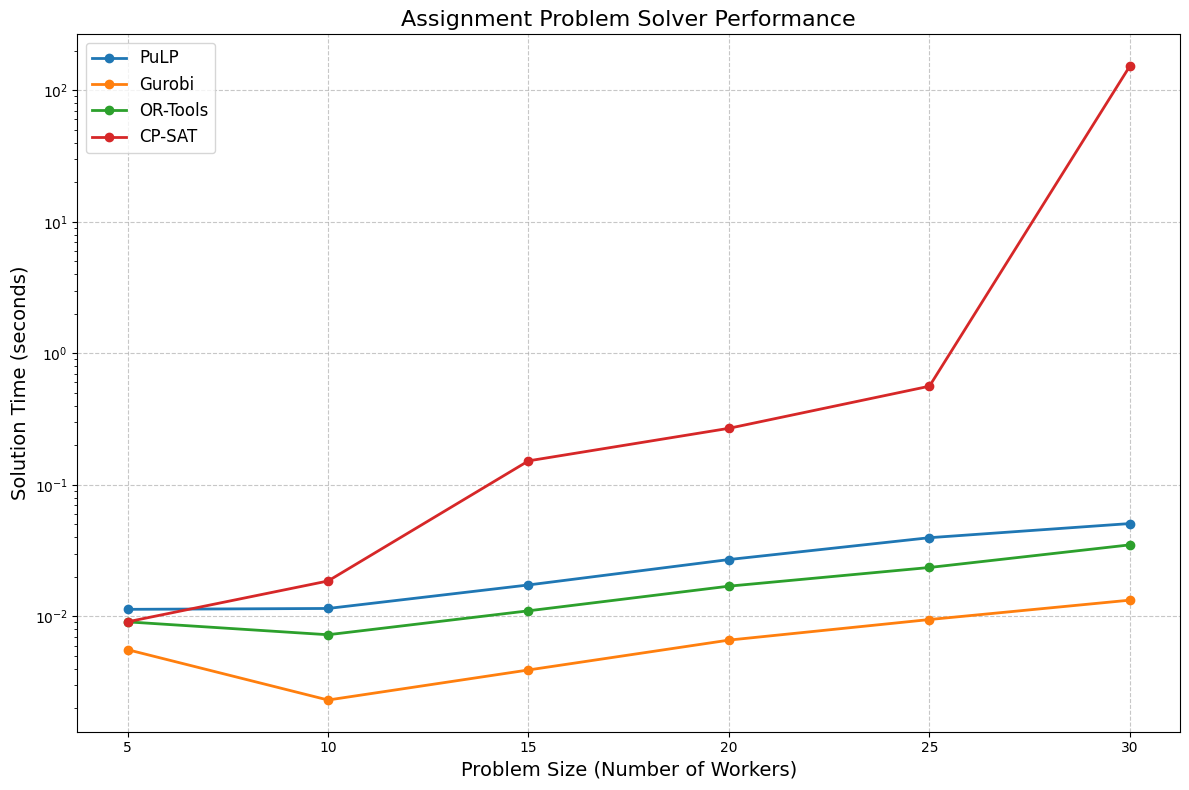


Results saved to 'solver_benchmark_results.csv'
Plot saved as 'solver_benchmark_results.png'


In [ ]:
if __name__ == "__main__":
    main()

Starting team assignment problem benchmark...

Testing with 10 workers and 10 tasks...
  OR-Tools: 0.01 ms, objective: 281.0
  PuLP: 0.01 ms, objective: 281.0
Restricted license - for non-production use only - expires 2026-11-23
  Gurobi: 0.01 ms, objective: 281.0
  CP-SAT: 0.02 ms, objective: 281.0

Testing with 20 workers and 20 tasks...
  OR-Tools: 0.02 ms, objective: 529.0
  PuLP: 0.03 ms, objective: 529.0
  Gurobi: 0.01 ms, objective: 529.0
  CP-SAT: 0.75 ms, objective: 529.0

Testing with 30 workers and 30 tasks...
  OR-Tools: 0.05 ms, objective: 497.0
  PuLP: 0.06 ms, objective: 497.0
  Gurobi: 0.01 ms, objective: 497.0
  CP-SAT: 2.24 ms, objective: 497.0

Testing with 40 workers and 40 tasks...
  OR-Tools: 0.14 ms, objective: 632.0
  PuLP: 0.20 ms, objective: 632.0
  Gurobi: 0.04 ms, objective: 632.0
  CP-SAT: 160.67 ms, objective: 632.0
Results saved to team_assignment_benchmark_results.csv


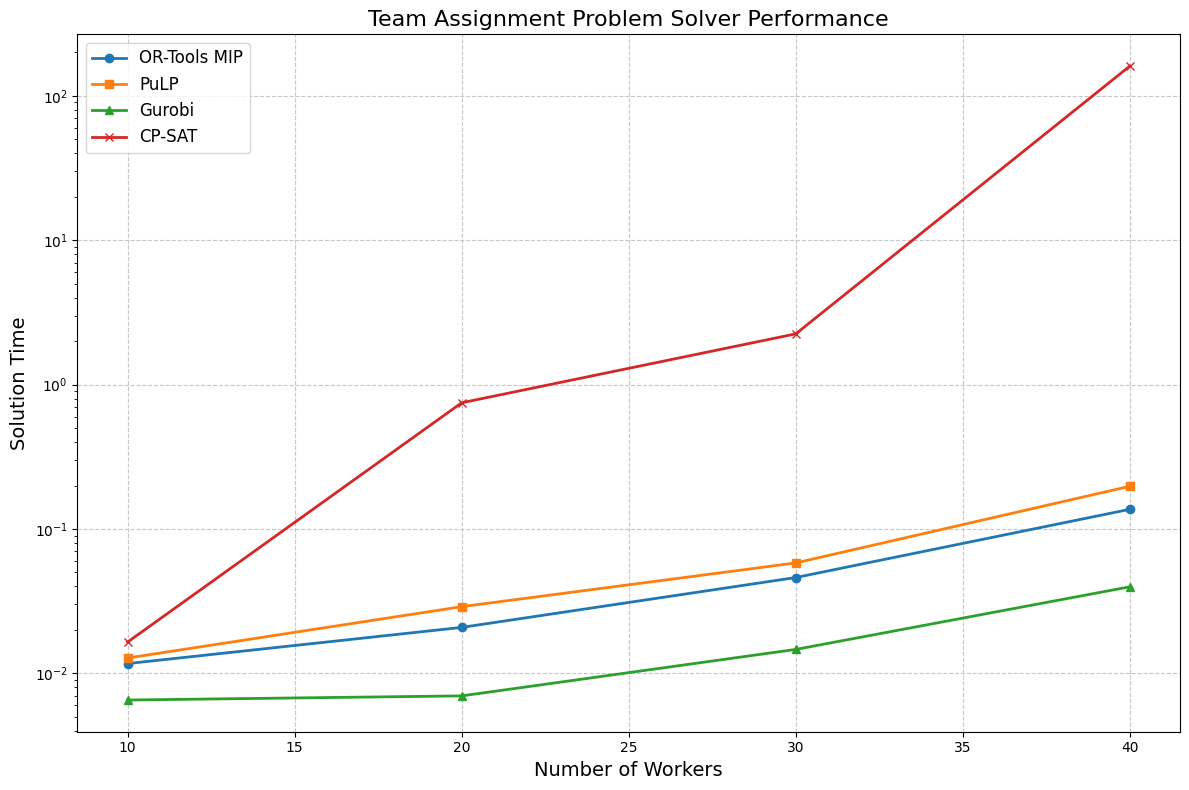


Summary of Results:
 Workers  Tasks  OR-Tools Time (ms)  OR-Tools Value  PuLP Time (ms)  PuLP Value  Gurobi Time (ms)  Gurobi Value  CP-SAT Time (ms)  CP-SAT Value
      10     10            0.011693           281.0        0.012772       281.0          0.006540         281.0          0.016472         281.0
      20     20            0.020817           529.0        0.028982       529.0          0.006986         529.0          0.748184         529.0
      30     30            0.046117           497.0        0.058193       497.0          0.014658         497.0          2.244796         497.0
      40     40            0.136868           632.0        0.197652       632.0          0.039788         632.0        160.669852         632.0

Statistical Summary of Performance (ms):
       OR-Tools Time (ms)  PuLP Time (ms)  Gurobi Time (ms)  CP-SAT Time (ms)
count            4.000000        4.000000          4.000000          4.000000
mean             0.053874        0.074400          0.016993  

In [ ]:
"""Benchmark comparison of different solvers for the team assignment problem with varying sizes."""
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model
import pulp

# Try to import Gurobi - might not be available on all systems
try:
    import gurobipy as gp
    from gurobipy import GRB
    GUROBI_AVAILABLE = True
except ImportError:
    GUROBI_AVAILABLE = False
    print("Gurobi not available. Benchmarking will skip Gurobi.")

def generate_problem_data(num_workers, num_tasks):
    """Generate random cost matrix and team assignments."""
    # Generate random costs between 10 and 200
    costs = np.random.randint(10, 200, size=(num_workers, num_tasks)).tolist()

    # Divide workers into two teams approximately evenly
    mid_point = num_workers // 2
    team1 = list(range(0, mid_point))
    team2 = list(range(mid_point, num_workers))

    # Maximum tasks per team (approximately half of total tasks)
    team_max = max(1, num_tasks // 2)

    return costs, team1, team2, team_max

def solve_with_ortools(costs, team1, team2, team_max):
    """Solve team assignment problem with OR-Tools MIP solver."""
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Start timing
    start_time = time.time()

    # Create solver
    solver = pywraplp.Solver.CreateSolver("SCIP")
    if not solver:
        return None, "Solver creation failed"

    # Variables
    x = {}
    for worker in range(num_workers):
        for task in range(num_tasks):
            x[worker, task] = solver.BoolVar(f"x[{worker},{task}]")

    # Constraints: Each worker assigned to at most 1 task
    for worker in range(num_workers):
        solver.Add(solver.Sum([x[worker, task] for task in range(num_tasks)]) <= 1)

    # Constraints: Each task assigned to exactly one worker
    for task in range(num_tasks):
        solver.Add(solver.Sum([x[worker, task] for worker in range(num_workers)]) == 1)

    # Constraints: Each team takes at most team_max tasks
    team1_tasks = []
    for worker in team1:
        for task in range(num_tasks):
            team1_tasks.append(x[worker, task])
    solver.Add(solver.Sum(team1_tasks) <= team_max)

    team2_tasks = []
    for worker in team2:
        for task in range(num_tasks):
            team2_tasks.append(x[worker, task])
    solver.Add(solver.Sum(team2_tasks) <= team_max)

    # Objective
    objective_terms = []
    for worker in range(num_workers):
        for task in range(num_tasks):
            objective_terms.append(costs[worker][task] * x[worker, task])
    solver.Minimize(solver.Sum(objective_terms))

    # Solve without output
    # solver.EnableOutput(False)
    status = solver.Solve()

    # Calculate time
    solve_time = (time.time() - start_time)  # milliseconds

    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        return solve_time, solver.Objective().Value()
    else:
        return solve_time, "No solution found"

def solve_with_pulp(costs, team1, team2, team_max):
    """Solve team assignment problem with PuLP."""
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Start timing
    start_time = time.time()

    # Create model
    model = pulp.LpProblem("Team_Assignment_Problem", pulp.LpMinimize)

    # Variables
    x = {}
    for worker in range(num_workers):
        for task in range(num_tasks):
            x[worker, task] = pulp.LpVariable(f"x_{worker}_{task}", cat=pulp.LpBinary)

    # Constraints: Each worker assigned to at most 1 task
    for worker in range(num_workers):
        model += pulp.lpSum(x[worker, task] for task in range(num_tasks)) <= 1

    # Constraints: Each task assigned to exactly one worker
    for task in range(num_tasks):
        model += pulp.lpSum(x[worker, task] for worker in range(num_workers)) == 1

    # Constraints: Each team takes at most team_max tasks
    model += pulp.lpSum(x[worker, task] for worker in team1 for task in range(num_tasks)) <= team_max
    model += pulp.lpSum(x[worker, task] for worker in team2 for task in range(num_tasks)) <= team_max

    # Objective
    model += pulp.lpSum(costs[worker][task] * x[worker, task] for worker in range(num_workers) for task in range(num_tasks))

    # Solve without output
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    # Calculate time
    solve_time = (time.time() - start_time)  # milliseconds

    if pulp.LpStatus[model.status] == 'Optimal':
        return solve_time, pulp.value(model.objective)
    else:
        return solve_time, "No solution found"

def solve_with_gurobi(costs, team1, team2, team_max):
    """Solve team assignment problem with Gurobi."""
    if not GUROBI_AVAILABLE:
        return None, "Gurobi not available"

    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Start timing
    start_time = time.time()

    # Create model
    model = gp.Model("Team_Assignment_Problem")
    model.setParam('OutputFlag', 0)  # Suppress output

    # Variables
    x = {}
    for worker in range(num_workers):
        for task in range(num_tasks):
            x[worker, task] = model.addVar(vtype=GRB.BINARY, name=f"x_{worker}_{task}")

    # Constraints: Each worker assigned to at most 1 task
    for worker in range(num_workers):
        model.addConstr(gp.quicksum(x[worker, task] for task in range(num_tasks)) <= 1)

    # Constraints: Each task assigned to exactly one worker
    for task in range(num_tasks):
        model.addConstr(gp.quicksum(x[worker, task] for worker in range(num_workers)) == 1)

    # Constraints: Each team takes at most team_max tasks
    model.addConstr(gp.quicksum(x[worker, task] for worker in team1 for task in range(num_tasks)) <= team_max)
    model.addConstr(gp.quicksum(x[worker, task] for worker in team2 for task in range(num_tasks)) <= team_max)

    # Objective
    model.setObjective(
        gp.quicksum(costs[worker][task] * x[worker, task] for worker in range(num_workers) for task in range(num_tasks)),
        GRB.MINIMIZE
    )

    # Solve
    model.optimize()

    # Calculate time
    solve_time = (time.time() - start_time)  # milliseconds

    if model.status == GRB.OPTIMAL:
        return solve_time, model.objVal
    else:
        return solve_time, "No solution found"

def solve_with_cpsat(costs, team1, team2, team_max):
    """Solve team assignment problem with CP-SAT."""
    num_workers = len(costs)
    num_tasks = len(costs[0])

    # Start timing
    start_time = time.time()

    # Create model
    model = cp_model.CpModel()

    # Variables
    x = {}
    for worker in range(num_workers):
        for task in range(num_tasks):
            x[worker, task] = model.NewBoolVar(f"x_{worker}_{task}")

    # Constraints: Each worker assigned to at most 1 task
    for worker in range(num_workers):
        model.Add(sum(x[worker, task] for task in range(num_tasks)) <= 1)

    # Constraints: Each task assigned to exactly one worker
    for task in range(num_tasks):
        model.Add(sum(x[worker, task] for worker in range(num_workers)) == 1)

    # Constraints: Each team takes at most team_max tasks
    model.Add(sum(x[worker, task] for worker in team1 for task in range(num_tasks)) <= team_max)
    model.Add(sum(x[worker, task] for worker in team2 for task in range(num_tasks)) <= team_max)

    # Objective
    objective_terms = []
    for worker in range(num_workers):
        for task in range(num_tasks):
            objective_terms.append(costs[worker][task] * x[worker, task])
    model.Minimize(sum(objective_terms))

    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = False  # Disable logging
    status = solver.Solve(model)

    # Calculate time
    solve_time = (time.time() - start_time)  # milliseconds

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        return solve_time, solver.ObjectiveValue()
    else:
        return solve_time, "No solution found"

def run_benchmark():
    """Run benchmarks for different solvers with varying problem sizes."""
    # Define problem sizes to test (number of workers, number of tasks)
    problem_sizes = [(a,a) for a in range(10,41,10)]

    # Store results in DataFrame
    results = {
        'Workers': [size[0] for size in problem_sizes],
        'Tasks': [size[1] for size in problem_sizes],
        'OR-Tools Time (ms)': [],
        'OR-Tools Value': [],
        'PuLP Time (ms)': [],
        'PuLP Value': [],
        'Gurobi Time (ms)': [],
        'Gurobi Value': [],
        'CP-SAT Time (ms)': [],
        'CP-SAT Value': []
    }

    # Run benchmarks for each problem size
    for workers, tasks in problem_sizes:
        print(f"\nTesting with {workers} workers and {tasks} tasks...")

        # Generate random problem data
        costs, team1, team2, team_max = generate_problem_data(workers, tasks)

        # Solve with OR-Tools MIP
        try:
            time_ortools, value_ortools = solve_with_ortools(costs, team1, team2, team_max)
            results['OR-Tools Time (ms)'].append(time_ortools)
            results['OR-Tools Value'].append(value_ortools)
            print(f"  OR-Tools: {time_ortools:.2f} ms, objective: {value_ortools}")
        except Exception as e:
            results['OR-Tools Time (ms)'].append(None)
            results['OR-Tools Value'].append(str(e))
            print(f"  OR-Tools failed: {e}")

        # Solve with PuLP
        try:
            time_pulp, value_pulp = solve_with_pulp(costs, team1, team2, team_max)
            results['PuLP Time (ms)'].append(time_pulp)
            results['PuLP Value'].append(value_pulp)
            print(f"  PuLP: {time_pulp:.2f} ms, objective: {value_pulp}")
        except Exception as e:
            results['PuLP Time (ms)'].append(None)
            results['PuLP Value'].append(str(e))
            print(f"  PuLP failed: {e}")

        # Solve with Gurobi
        try:
            time_gurobi, value_gurobi = solve_with_gurobi(costs, team1, team2, team_max)
            results['Gurobi Time (ms)'].append(time_gurobi)
            results['Gurobi Value'].append(value_gurobi)
            print(f"  Gurobi: {time_gurobi:.2f} ms, objective: {value_gurobi}")
        except Exception as e:
            results['Gurobi Time (ms)'].append(None)
            results['Gurobi Value'].append(str(e))
            print(f"  Gurobi failed: {e}")

        # Solve with CP-SAT
        try:
            time_cpsat, value_cpsat = solve_with_cpsat(costs, team1, team2, team_max)
            results['CP-SAT Time (ms)'].append(time_cpsat)
            results['CP-SAT Value'].append(value_cpsat)
            print(f"  CP-SAT: {time_cpsat:.2f} ms, objective: {value_cpsat}")
        except Exception as e:
            results['CP-SAT Time (ms)'].append(None)
            results['CP-SAT Value'].append(str(e))
            print(f"  CP-SAT failed: {e}")

    return pd.DataFrame(results)

def plot_results(results_df):
    """Create plots comparing solver performance."""
    # Extract timing data, ignoring any None values
    workers = results_df['Workers']
    times_ortools = results_df['OR-Tools Time (ms)'].copy()
    times_pulp = results_df['PuLP Time (ms)'].copy()
    times_gurobi = results_df['Gurobi Time (ms)'].copy()
    times_cpsat = results_df['CP-SAT Time (ms)'].copy()

    # Create figure and axis
    plt.figure(figsize=(12, 8))

    # Plot the data
    plt.plot(workers, times_ortools, marker='o', linewidth=2, label='OR-Tools MIP')
    plt.plot(workers, times_pulp, marker='s', linewidth=2, label='PuLP')
    if GUROBI_AVAILABLE:
        plt.plot(workers, times_gurobi, marker='^', linewidth=2, label='Gurobi')
    plt.plot(workers, times_cpsat, marker='x', linewidth=2, label='CP-SAT')

    # Add labels and title
    plt.title('Team Assignment Problem Solver Performance', fontsize=16)
    plt.xlabel('Number of Workers', fontsize=14)
    plt.ylabel('Solution Time', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Use log scale for better visibility of differences
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('solver_performance.png', dpi=300)
    plt.show()

    # Also create a table of results
    print("\nSummary of Results:")
    print(results_df.to_string(index=False))

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Run the benchmarks
    print("Starting team assignment problem benchmark...")
    results_df = run_benchmark()

    # Save results to CSV
    results_df.to_csv("team_assignment_benchmark_results.csv", index=False)
    print("Results saved to team_assignment_benchmark_results.csv")

    # Plot and display the results
    plot_results(results_df)

    # Show statistical summary
    print("\nStatistical Summary of Performance (ms):")
    performance_cols = ['OR-Tools Time (ms)', 'PuLP Time (ms)', 'CP-SAT Time (ms)']
    if GUROBI_AVAILABLE:
        performance_cols.insert(2, 'Gurobi Time (ms)')

    stats_df = results_df[performance_cols].describe()
    print(stats_df.to_string())

    # Determine fastest solver for each problem size
    fastest_solver = []
    for idx, row in results_df.iterrows():
        times = [
            (row['OR-Tools Time (ms)'], 'OR-Tools'),
            (row['PuLP Time (ms)'], 'PuLP'),
            (row['CP-SAT Time (ms)'], 'CP-SAT')
        ]

        if GUROBI_AVAILABLE and row['Gurobi Time (ms)'] is not None:
            times.append((row['Gurobi Time (ms)'], 'Gurobi'))

        valid_times = [(t, name) for t, name in times if t is not None]
        if valid_times:
            fastest = min(valid_times, key=lambda x: x[0])
            fastest_solver.append((row['Workers'], row['Tasks'], fastest[1], fastest[0]))

    print("\nFastest solver for each problem size:")
    for workers, tasks, solver, time in fastest_solver:
        print(f"  {workers} workers, {tasks} tasks: {solver} ({time:.2f} ms)")

    print("\nBenchmark completed successfully!")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 10 rows, 25 columns and 50 nonzeros
Model fingerprint: 0xcd03d9ac
Variable types: 0 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 334.0000000
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 50 nonzeros
Variable types: 0 continuous, 25 integer (25 binary)

Root relaxation: objective 1.510000e+02, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     151.0000000  151.00000  0.

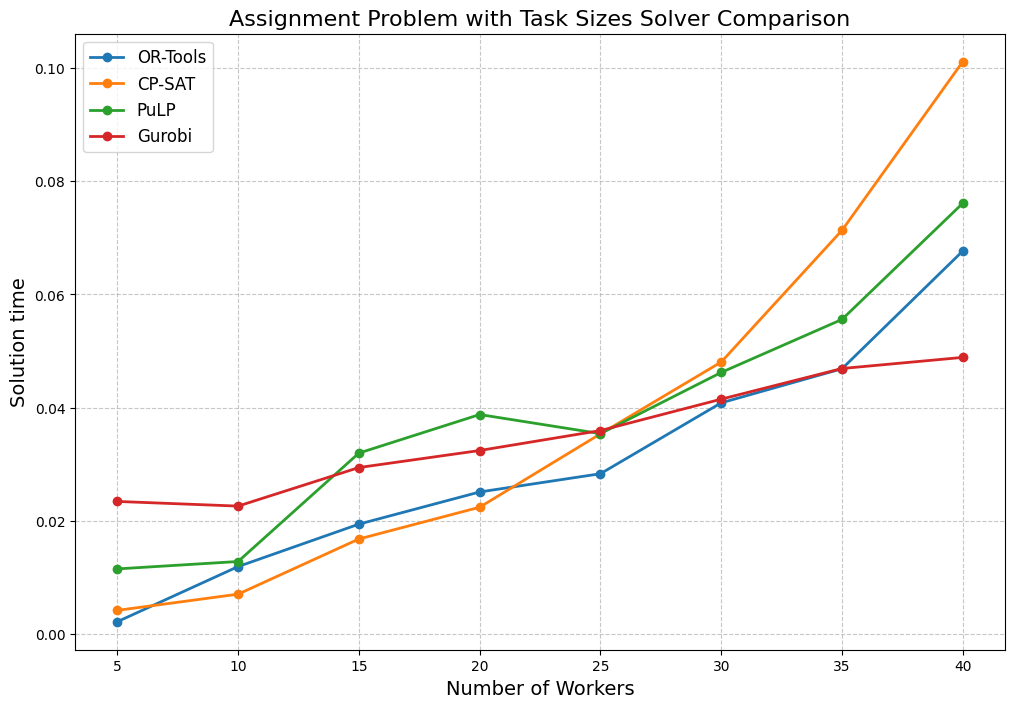

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model
import pulp
from gurobipy import Model, GRB

def generate_random_problem(n):
    costs = np.random.randint(10, 100, size=(n, n)).tolist()
    task_sizes = np.random.randint(1, 10, size=n).tolist()
    total_size_max = 15
    return costs, task_sizes, total_size_max

def average_time(solver_function, n, costs, task_sizes, total_size_max, trials=5):
    times = []
    for _ in range(trials):
        times.append(solver_function(n, costs, task_sizes, total_size_max))
    return sum(times) / trials

def solve_with_ortools_scip(n, costs, task_sizes, total_size_max):
    solver = pywraplp.Solver.CreateSolver("SCIP")
    x = {(i, j): solver.BoolVar(f"x[{i},{j}]") for i in range(n) for j in range(n)}

    for i in range(n):
        solver.Add(sum(task_sizes[j] * x[i, j] for j in range(n)) <= total_size_max)
    for j in range(n):
        solver.Add(sum(x[i, j] for i in range(n)) == 1)
    solver.Minimize(solver.Sum(costs[i][j] * x[i, j] for i in range(n) for j in range(n)))

    start = time.time()
    solver.Solve()
    return time.time() - start

def solve_with_cp_sat(n, costs, task_sizes, total_size_max):
    model = cp_model.CpModel()
    x = {(i, j): model.NewBoolVar(f"x[{i},{j}]") for i in range(n) for j in range(n)}

    for i in range(n):
        model.Add(sum(task_sizes[j] * x[i, j] for j in range(n)) <= total_size_max)
    for j in range(n):
        model.AddExactlyOne(x[i, j] for i in range(n))
    model.Minimize(sum(costs[i][j] * x[i, j] for i in range(n) for j in range(n)))

    solver = cp_model.CpSolver()
    start = time.time()
    solver.Solve(model)
    return time.time() - start

def solve_with_pulp(n, costs, task_sizes, total_size_max):
    prob = pulp.LpProblem("Assignment", pulp.LpMinimize)
    x = {(i, j): pulp.LpVariable(f"x_{i}_{j}", cat="Binary") for i in range(n) for j in range(n)}

    for i in range(n):
        prob += sum(task_sizes[j] * x[i, j] for j in range(n)) <= total_size_max
    for j in range(n):
        prob += sum(x[i, j] for i in range(n)) == 1
    prob += pulp.lpSum(costs[i][j] * x[i, j] for i in range(n) for j in range(n))

    start = time.time()
    prob.solve()
    return time.time() - start

def solve_with_gurobi(n, costs, task_sizes, total_size_max):
    model = Model()
    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")

    for i in range(n):
        model.addConstr(sum(task_sizes[j] * x[i, j] for j in range(n)) <= total_size_max)
    for j in range(n):
        model.addConstr(sum(x[i, j] for i in range(n)) == 1)
    model.setObjective(sum(costs[i][j] * x[i, j] for i in range(n) for j in range(n)), GRB.MINIMIZE)

    start = time.time()
    model.optimize()
    return time.time() - start

# def benchmark():
sizes = list(range(5, 41, 5))
times = {"OR-Tools": [], "CP-SAT": [], "PuLP": [], "Gurobi": []}

for n in sizes:
    costs, task_sizes, total_size_max = generate_random_problem(n)
    times["OR-Tools"].append(average_time(solve_with_ortools_scip, n, costs, task_sizes, total_size_max))
    times["CP-SAT"].append(average_time(solve_with_cp_sat, n, costs, task_sizes, total_size_max))
    times["PuLP"].append(average_time(solve_with_pulp, n, costs, task_sizes, total_size_max))
    times["Gurobi"].append(average_time(solve_with_gurobi, n, costs, task_sizes, total_size_max))

plt.figure(figsize=(12, 8))
for solver, time_data in times.items():
    plt.plot(sizes, time_data, marker='o', linewidth=2, label=solver)


plt.xlabel("Number of Workers", fontsize=14)
plt.ylabel("Solution time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Assignment Problem with Task Sizes Solver Comparison", fontsize=16)
plt.legend(fontsize=12)
plt.show()

# if __name__ == "__main__":
#     benchmark()


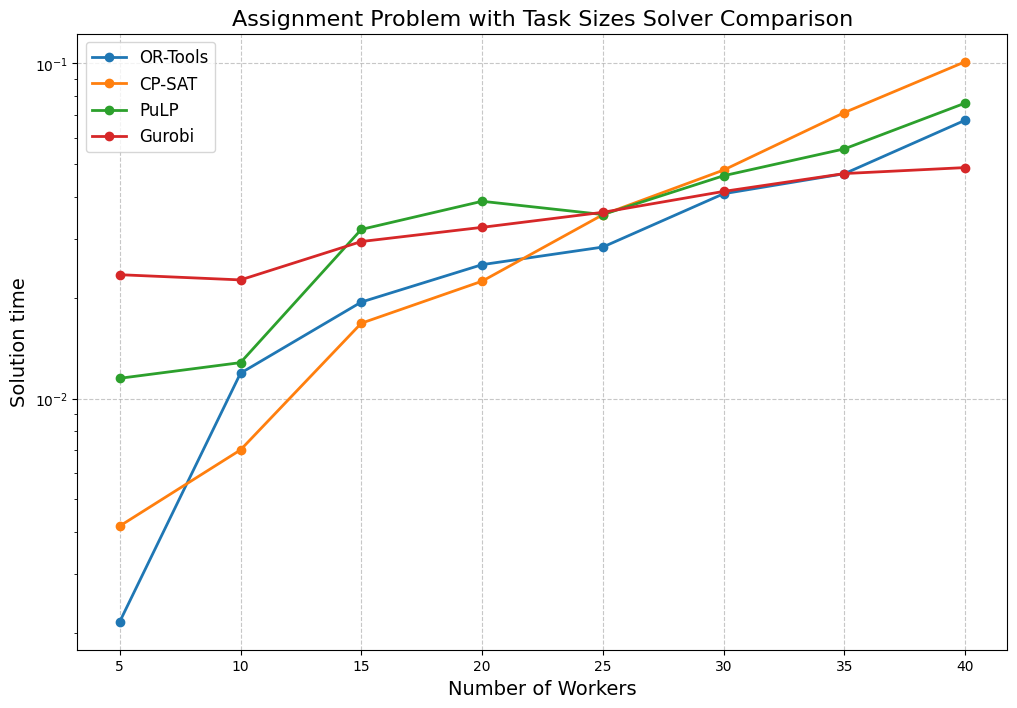

In [5]:
plt.figure(figsize=(12, 8))
for solver, time_data in times.items():
    plt.plot(sizes, time_data, marker='o', linewidth=2, label=solver)


plt.xlabel("Number of Workers", fontsize=14)
plt.ylabel("Solution time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Assignment Problem with Task Sizes Solver Comparison", fontsize=16)
plt.legend(fontsize=12)
plt.yscale('log')
plt.show()